# Spectral Index Map Between ALMA bands 6 and 8 for B228/IRAS15398

## Define Equations:

**Alpha is the spectral index calculated from observed fluxes:**
alpha_mm = np.log10(Flux1/Flux2)/np.log10(lambda2/(lambda1))

**beta is the spectral index aplpa minus 2:**
beta = (np.log10(Flux1/Flux2)/np.log10(lambda2/(lambda1))) - 2

In [45]:
#imports needed to make the spectral index map

%matplotlib inline
import numpy as np
from spectral_cube import SpectralCube
from astropy import units as u
from matplotlib import pyplot as plt
import warnings 
from astropy.coordinates import SkyCoord
from astroquery.splatalogue import Splatalogue
import aplpy
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.wcs import WCS
from astropy.io import fits
import statistics

warnings.filterwarnings('ignore') # turns of annoying red warning boxes

In [46]:
#define files names

band6 = '/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/B228_regrid.fits'# the title is regrid but its not actually regridded I'm just tired and named the file wrong
band8 = '/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/B228jes_regrid.fits'
#B228jesS2 ='/Users/hannahshoemaker/VICO_dust/IRAS15398/IRAS_data/B228403_regrid.fits'

In [52]:
rmsband6 = (0.00012+0.00013+0.0001+0.000098+0.00014)/5
rmsband8 = 0.0009
print(rmsband6,rmsband8)

0.0001176 0.0009


In [53]:
def Read_Cube(file_name):
    '''
    Read_Cube takes the file name, uses the package SpectralCube to read it and returns the cube
    '''
    cube = (SpectralCube.read(file_name))
    cube.spectral_axis #making sure we use Hz and not Velocity
    return cube

def Draw_Box(cube):
    '''
    Draw_Box takes the cube returned from Read_Cube and cuts the cube down into a smaller "cutcube". Returns cutcube.
    
    "boxsize" is an arbitrary variable and has no dependance on the data itself. It is a box of a certain number of
    pixels, decreasing the variable "boxsize" is effectivly zooming in on the image. It is likely that you will need 
    to change this parameter
    '''
    boxsize=50
    drawbox_x = [int(cube.shape[2]/2-boxsize),int(cube.shape[2]/2+boxsize)]
    drawbox_y = [int(cube.shape[1]/2-boxsize),int(cube.shape[1]/2+boxsize)]
    cutcube = cube.subcube(xlo = drawbox_x[0],xhi = drawbox_x[1],ylo = drawbox_y[0],yhi = drawbox_y[1])
    return cutcube
        
def Spectral_Index(cube,cube2):
    '''
    Spectral_Index takes the cube created for each file, reads the rest frequency from the header, takes the
    flux at every pixel and then uses theses values to calculate alpha millimeter. Returns alpha millimeter
    '''
    freq1= cube.header['RESTFRQ'] *u.Hz
    freq2= cube2.header['RESTFRQ'] *u.Hz
    Flux1 = cube[0,0:cube.shape[1],0:cube.shape[2]] # flux at every pixel 
    Flux2 = cube2[0,0:cube2.shape[1],0:cube2.shape[2]] # flux at every pixel
    alpha = np.log10(Flux1/Flux2)/np.log10(freq1.value/(freq2.value)) #calculate alpha
    return alpha
   

In [54]:
# define functions that compute each of the spectral indicies
    
def Spectral_Index_beta(file1,rms1,file2,rms2,colorscheme):
    '''
    Spectral_Index_Beta takes the files names and the rms of each respective file , reads it in using Read_Cube,
    draws an image for beta, masking all emission below 3 sigma for each observation and draws contours at 3, 5, 10 
    and 50 sigma. 
    '''
    cube1 = Read_Cube(file1)
    cube2 = Read_Cube(file2)
    cutcube1 = Draw_Box(cube1)
    cutcube2 = Draw_Box(cube2)
 
    print('3\u03C3 for your first observation is', 3*rms1,'Jy/beam')
    print('3\u03C3 for your first observation is', 3*rms2,'Jy/beam')

    #define mask so only emission above 3 sigma is colored
    mask = (cutcube1[0,:,:].value > 3*rms1.value) & (cutcube2[0,:,:].value > 3*rms2.value) 
    #mask = (cutcube1[0,:,:].value > threesig.value) 
    #mask = (cutcube2[0,:,:].value > threesigjes.value)

    #make new cut cubes using the newly defined mask
    newcut = cutcube1.with_mask(mask)
    newcut2 = cutcube2.with_mask(mask)
    
    alpha = Spectral_Index(newcut,newcut2)
    beta = alpha - 2

    fig = aplpy.FITSFigure(beta.hdu, dimensions=[0,1])
    fig.add_beam(major=cube1.header['bmaj'],minor=cube1.header['bmin'],angle=cube1.header['bpa'],fill=True, color='black')
    fig.add_beam(major=cube2.header['bmaj'],minor=cube2.header['bmin'],angle=cube2.header['bpa'],fill=False, color='grey')
        
    plt.imshow(beta.value, cmap = colorscheme)

    plt.colorbar(spacing = 'proportional',shrink=0.9)

    fig.axis_labels.show()
    fig.axis_labels.set_xtext("Right Ascension (ICRS)") 
    fig.axis_labels.set_ytext("Declination (ICRS)")
    
    print("The black contours are for band 6, the grey contours are for band 8")

    # draw contours on file 1 data
    levs_rms = np.arange(0,1000)*rms1.value
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[3:4],colors='black')
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[5:6], colors='black')
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[10:11], colors='black')
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[50:51], colors='black')
        
    #draw contours wone file 2 data
    levs_rms = np.arange(0,1000)*rms2.value
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[3:4],colors='grey')
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[5:6], colors='grey')
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[10:11], colors='grey')
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[50:51], colors='grey')
        
    return

def Spectral_Index_alpha_mm(file1,rms1,file2,rms2,colorscheme):
    ''''
    Spectral_Index_alpha_mm takes the files names and the rms of each respective file , reads it in using Read_Cube,
    draws an image for alpha, masking all emission below 3 sigma for each observation and draws contours at 3, 5, 10 
    and 50 sigma. 
    '''
        
    cube1 = Read_Cube(file1)
    cube2 = Read_Cube(file2)
    cutcube1 = Draw_Box(cube1)
    cutcube2 = Draw_Box(cube2)
 
    print('3\u03C3 for your first observation is', 3*rms1,'Jy/beam')
    print('3\u03C3 for your second observation is', 3*rms2,'Jy/beam')

    mask = (cutcube1[0,:,:].value > 3*rms1.value) & (cutcube2[0,:,:].value > 3*rms2.value)

    newcut = cutcube1.with_mask(mask)
    newcut2 = cutcube2.with_mask(mask)
    
    alpha = Spectral_Index(newcut,newcut2)

    fig = aplpy.FITSFigure(alpha.hdu, dimensions=[0,1])
    fig.add_beam(major=cube1.header['bmaj'],minor=cube1.header['bmin'],angle=cube1.header['bpa'],fill=True, color='black')
    fig.add_beam(major=cube2.header['bmaj'],minor=cube2.header['bmin'],angle=cube2.header['bpa'],fill=False, color='grey')
        
    plt.imshow(alpha.value, cmap = colorscheme)

    plt.colorbar(spacing = 'proportional',shrink=0.9)
     
    fig.axis_labels.show()
    fig.axis_labels.set_xtext("Right Ascension (ICRS)") 
    fig.axis_labels.set_ytext("Declination (ICRS)")
    
    print("The black contours are for band6 , the grey contours are for band 8")

    # draw contours on file 1 data
    levs_rms = np.arange(0,1000)*rms1.value
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[3:4],colors='black')
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[5:6], colors='black')
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[10:11], colors='black')
    fig.show_contour(cutcube1[0,:,:].hdu.data,levels = levs_rms[50:51], colors='black')
        
    #draw contours on file 2 data
    levs_rms = np.arange(0,1000)*rms2.value
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[3:4],colors='grey')
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[5:6], colors='grey')
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[10:11], colors='grey')
    fig.show_contour(cutcube2[0,:,:].hdu.data,levels = levs_rms[50:51], colors='grey')
        
    return

In [55]:
## I would like to try this again with a more robust defenition of RMS

3σ for your first observation is 0.0003528 Jy Jy/beam
3σ for your second observation is 0.0027 Jy Jy/beam
The black contours are for band6 , the grey contours are for band 8


3σ for your first observation is 0.0003528 Jy Jy/beam
3σ for your first observation is 0.0027 Jy Jy/beam
The black contours are for band 6, the grey contours are for band 8


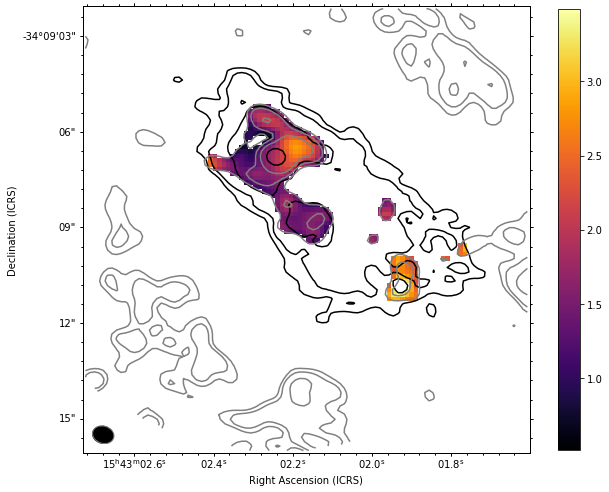

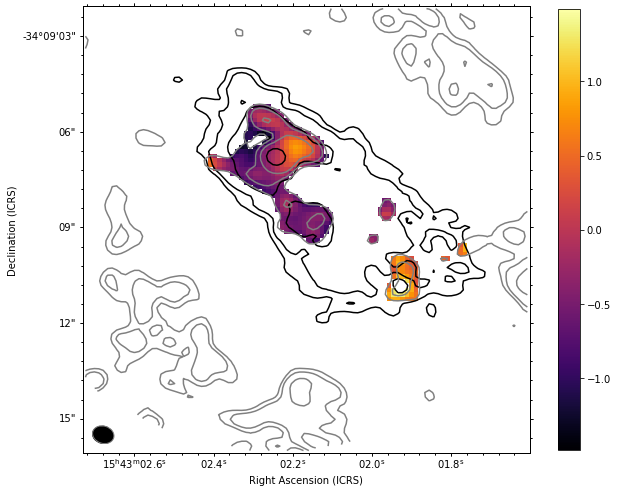

In [56]:
Spectral_Index_alpha_mm(band6,rmsband6*u.Jy,band8,rmsband8*u.Jy , 'inferno')
Spectral_Index_beta(band6,rmsband6*u.Jy,band8,rmsband8*u.Jy, 'inferno')